In [45]:
# Load required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.filters import threshold_otsu
from skimage.color import rgb2lab
from scipy.ndimage import gaussian_filter
import rasterio
from rasterio.plot import show
from PIL import Image


## Load and Display Image


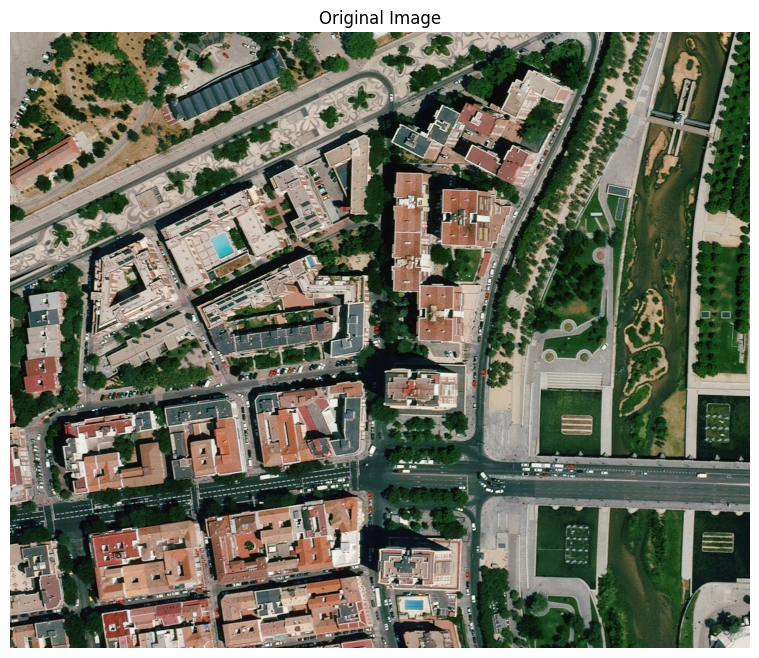

In [16]:
# Load an image (GeoTIFF or standard formats)
def load_image(file_path):
    try:
        if file_path.endswith('.tif'):
            # Use rasterio for GeoTIFFs
            with rasterio.open(file_path) as src:
                image = src.read([b for b in range(1, src.count + 1)]).transpose(1, 2, 0)  # RGB(A)
                return image
        else:
            # Use OpenCV or PIL for standard formats
            return cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Visualize the image
def plot_image(image, title="Image"):
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()


# file_path = 'input\ESPG-4326-orthophoto.tif'
file_path = 'input\MADRID_RGB.tif'

image = load_image(file_path)
if image is not None:
    plot_image(image, "Original Image")


## Image Preprocessing

### LAB Image Color Space

Expected Results:

- **L**: A grayscale image showing brightness across the image.
- **A**: Red-dominated areas should appear positive (bright), while green-dominated areas should appear negative (dark).
- **B**: Highlights blue-to-yellow dominance.

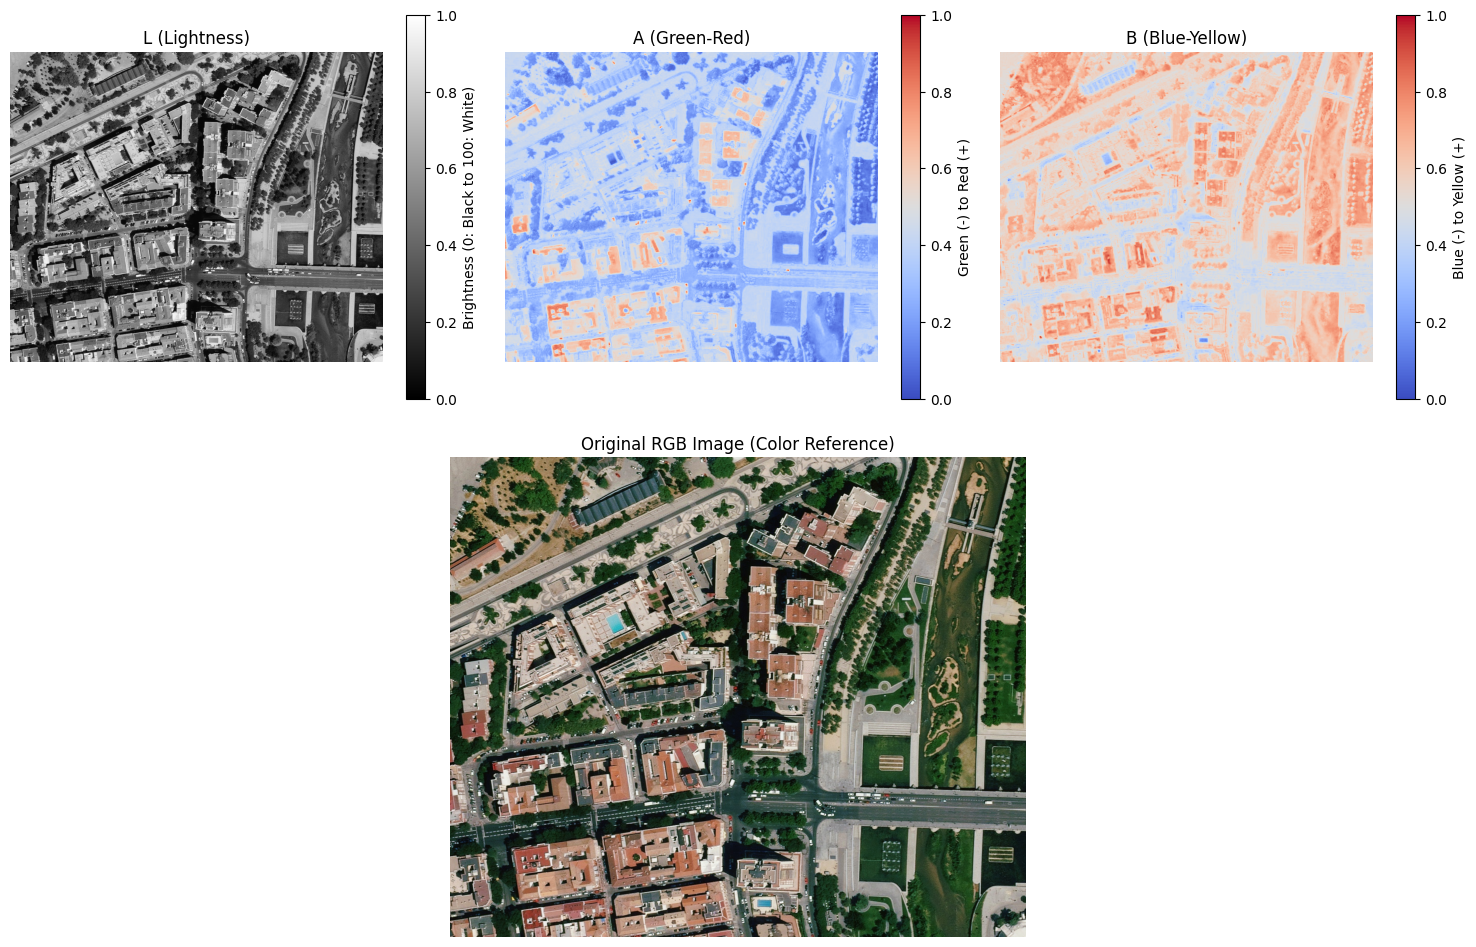

In [49]:
# Set up the grid layout using gridspec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, height_ratios=[1, 1])  # Equal height for both rows

# First Row: LAB Channels
# L (Lightness)
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(L, cmap='gray')
ax1.set_title("L (Lightness)")
ax1.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=ax1, shrink=0.8)
cbar.set_label("Brightness (0: Black to 100: White)")

# A (Green-Red)
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(A, cmap='coolwarm')
ax2.set_title("A (Green-Red)")
ax2.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax2, shrink=0.8)
cbar.set_label("Green (-) to Red (+)")

# B (Blue-Yellow)
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(B, cmap='coolwarm')
ax3.set_title("B (Blue-Yellow)")
ax3.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax3, shrink=0.8)
cbar.set_label("Blue (-) to Yellow (+)")

# Second Row: Original Image in Color
ax4 = fig.add_subplot(gs[1, :])  # Span all columns in the second row
ax4.imshow(image)
ax4.set_title("Original RGB Image (Color Reference)")
ax4.axis("off")

plt.tight_layout()
plt.show()

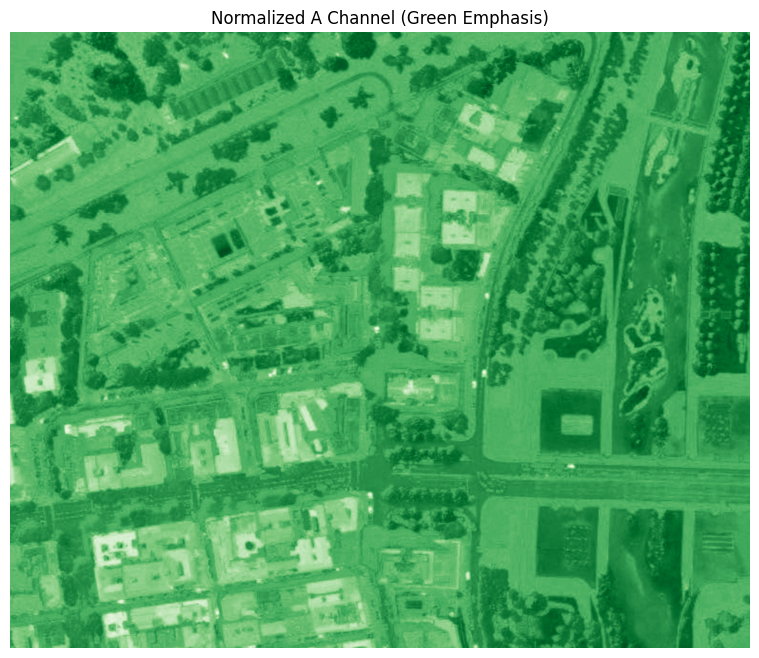

In [39]:
# Normalize the green-dominant range in the A channel
A_normalized = -A  # Flip to make green positive
A_normalized = (A_normalized - A_normalized.min()) / (A_normalized.max() - A_normalized.min())
# A_normalized = -A  # Flip to make green positive

# Visualize normalized green emphasis
plt.figure(figsize=(10, 8))
plt.imshow(A_normalized, cmap='Greens')
plt.title("Normalized A Channel (Green Emphasis)")
plt.axis("off")
plt.show()


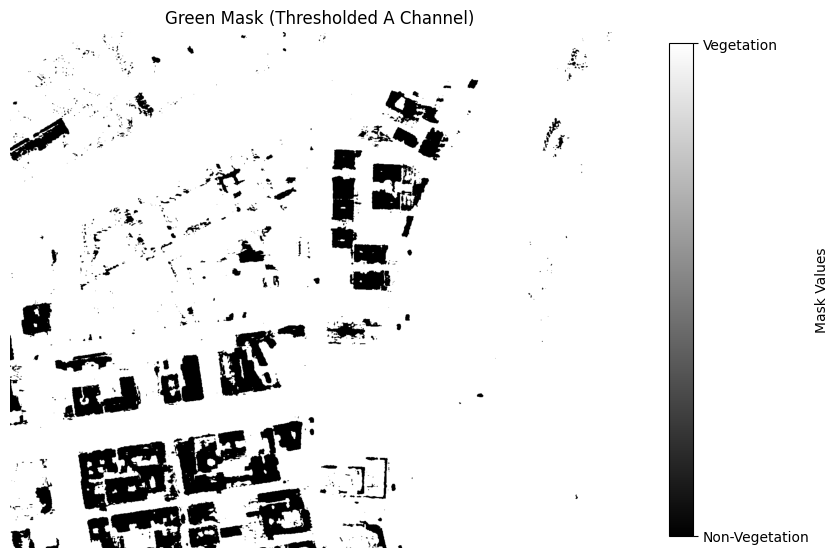

In [29]:
# Threshold green areas
green_mask = A_normalized > 0.5  # Adjust threshold as needed

# Green Mask Visualization
plt.figure(figsize=(10, 8))
plt.imshow(green_mask, cmap='gray')
plt.title("Green Mask (Thresholded A Channel)")
plt.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=plt.gca(), shrink=0.8)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Non-Vegetation", "Vegetation"])
cbar.set_label("Mask Values")
plt.show()



## Preprocessing

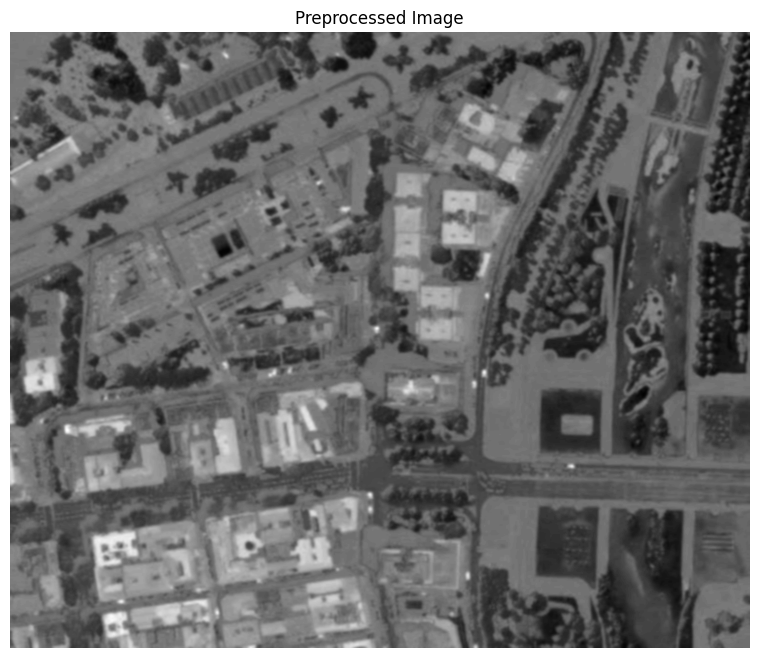

In [30]:
# Convert to LAB color space and smooth the image
def preprocess_image(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    smoothed_image = gaussian_filter(lab_image[:, :, 1], sigma=2)  # Apply Gaussian filter on 'A' channel
    return smoothed_image

smoothed_image = preprocess_image(image)
plt.figure(figsize=(10, 8))
plt.imshow(smoothed_image, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()


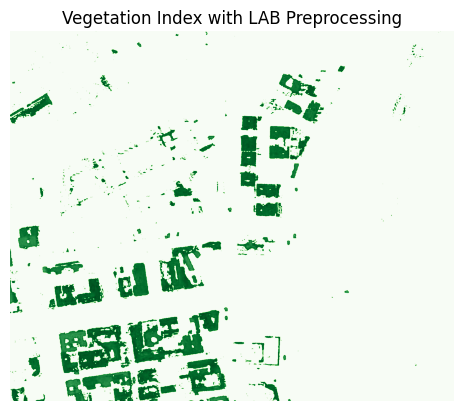

In [31]:
# Step 1: Convert to LAB
lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
L, A, B = cv2.split(lab_image)

# Step 2: Normalize and Enhance Green Areas
green_emphasis = (A - A.min()) / (A.max() - A.min())  # Normalize A channel

# Step 3: Mask Non-Green Areas
green_mask = green_emphasis > 0.5  # Thresholding for green dominance

# Step 4: Calculate Vegetation Index (ExG) in RGB
r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
exg = 2 * g - r - b

# Step 5: Apply the Mask to the Index
exg_masked = exg * green_mask

# Visualize the Final Result
plt.imshow(exg_masked, cmap='Greens')
plt.title("Vegetation Index with LAB Preprocessing")
plt.axis("off")
plt.show()

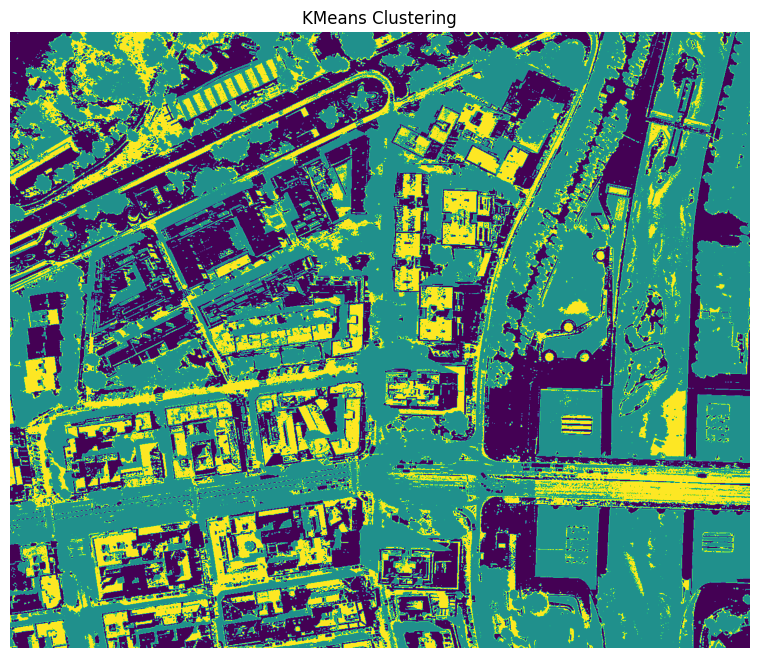

In [32]:
# Flatten the image for clustering
def cluster_image(image, n_clusters=3):
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels)
    clustered_image = labels.reshape(image.shape[:2])
    return clustered_image

clustered = cluster_image(image)
plt.figure(figsize=(10, 8))
plt.imshow(clustered, cmap='viridis')
plt.title("KMeans Clustering")
plt.axis('off')
plt.show()


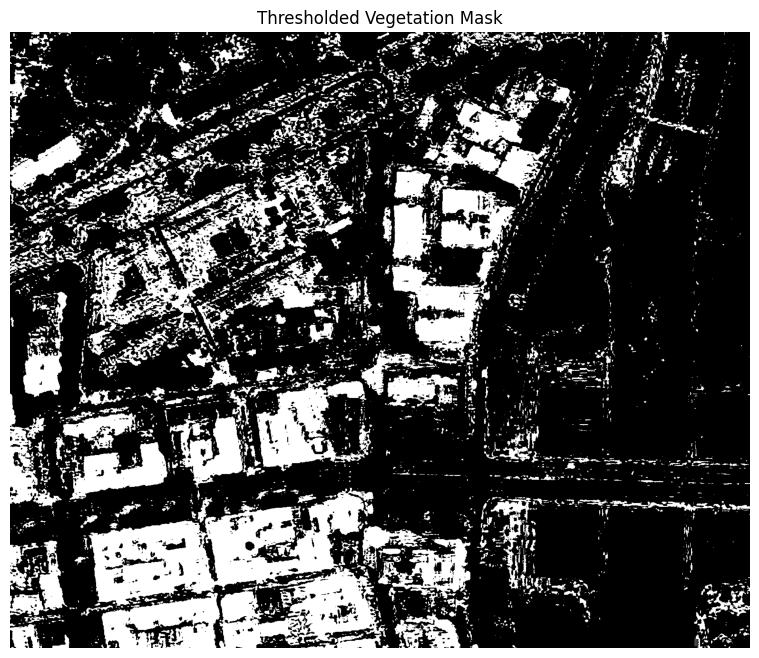

In [33]:
# Apply Otsu thresholding to a spectral index (e.g., Excess Green)
def calculate_excess_green(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    exg = 2 * g - r - b  # Excess green calculation
    return exg

def threshold_image(image):
    exg = calculate_excess_green(image)
    thresh = threshold_otsu(exg)
    binary = exg > thresh
    return binary

binary_mask = threshold_image(image)
plt.figure(figsize=(10, 8))
plt.imshow(binary_mask, cmap='gray')
plt.title("Thresholded Vegetation Mask")
plt.axis('off')
plt.show()


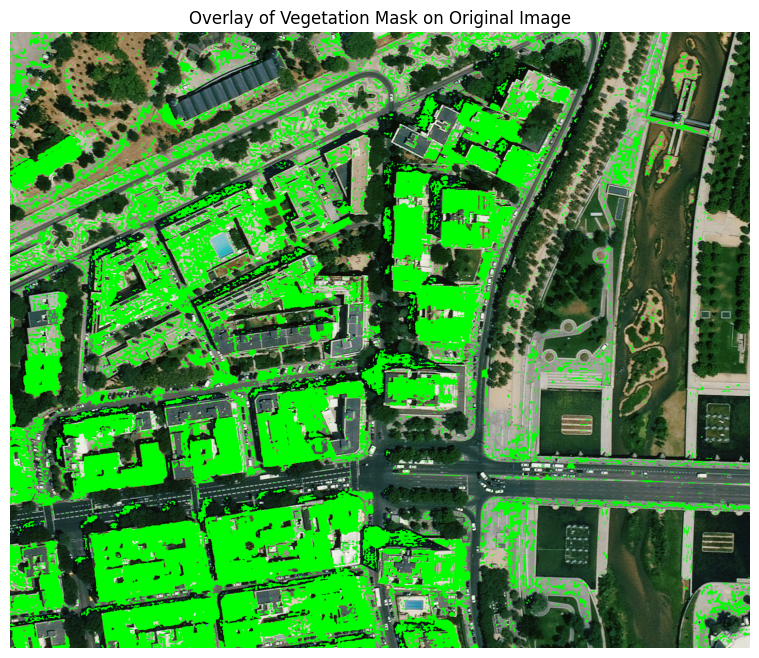

In [34]:
# Overlay binary mask onto the original image
def overlay_mask(image, mask):
    overlay = image.copy()
    overlay[mask] = [0, 255, 0]  # Highlight vegetation in green
    return overlay

overlay = overlay_mask(image, binary_mask)
plt.figure(figsize=(10, 8))
plt.imshow(overlay)
plt.title("Overlay of Vegetation Mask on Original Image")
plt.axis('off')
plt.show()
